## Задача 5-1. A\* поиск в задаче о кратчайших путях.

В этой задаче Вам предлагается реализовать поиск кратчайших путей в графе с помощью A\*-поиска с использованием эвристической функции («потенциала»), основанном на landmarks. Теоретические основы можно посмотреть [здесь](http://logic.pdmi.ras.ru/midas/sites/default/files/midas-werneck.pdf), слайды 20—36.

Вам предлагается скачать [отсюда](http://www.diag.uniroma1.it/challenge9/download.shtml) файлы “Travel time graph” и “Coordinates” для штата Флорида. Для Вашего удобства они также размещены в архиве `florida.7z` в настоящем репозитории на GitHub.

Функции `read_node_coords` и `read_arcs` возвращают соответственно координаты вершин графа (отнормированные; координаты нужны только для обеспечения возможности выбора landmarks “по периметру графа”) и структура дуг графа.

In [12]:
import math
from typing import List, Dict, Tuple
from collections import namedtuple, defaultdict

from heapdict import *

import matplotlib.pyplot as plt
import numpy as np

from tqdm import *

In [2]:

Coords = namedtuple('Coords', ['x', 'y'])

def read_node_coords(filename='USA-road-d.FLA.co') -> List[Coords]:
    node_coords = []
    
    with open(filename, 'r') as coord_file:
        for line in coord_file:
            if line.startswith('v '):
                node_number, x, y = map(int, line.split()[1:])
                node_coords.append(Coords(x, y))
    
    minx = min(c.x for c in node_coords)
    miny = min(c.y for c in node_coords)
    for i, c in enumerate(node_coords):
        node_coords[i] = Coords(c.x-minx, c.y-miny)
    
    return node_coords


def read_arcs(filename='USA-road-t.FLA.gr') -> Dict[int, Dict[int, float]]:
    adjacency_lists = defaultdict(dict)
    
    with open(filename, 'r') as coord_file:
        for line in coord_file:
            if line.startswith('a '):
                node_from, node_to, weight = map(int, line.split()[1:])
                adjacency_lists[node_from-1][node_to-1] = weight
                
    return adjacency_lists

Реализуйте процедуру `good_old_dijkstra`, которая для пары номеров вершин графа ищет кратчайший путь между ними и возвращает список номеров вершин, образующих оптимальный путь и его длину.

In [14]:
def good_old_dijkstra(adjacency_lists: Dict[int, Dict[int, float]], 
                      node_from: int, node_to=None) -> Tuple[List[int], float]:
    """
        calculate distance in graph with positive costs of edges
        if node_to is None, Dict(node_i: dist) is returned -- used for efficient
        landmarks precalculations
    """
    not_used = heapdict()
    dist = defaultdict(lambda: math.inf)
    prev = defaultdict(lambda: -1)
    
    for key in adjacency_lists.keys():
        not_used[key] = math.inf
    
    not_used[node_from] = 0
    dist[node_from] = 0
    prev[node_from] = node_from
    
    def select_minimal_not_used():
        return not_used.popitem()[0]
    
    for _ in range(len(adjacency_lists)):
        cur_v = select_minimal_not_used()
        for to in adjacency_lists[cur_v].keys():
            w = adjacency_lists[cur_v][to]
            
            new_d = dist[cur_v] + w
            if new_d < dist[to]:
                dist[to] = new_d
                not_used[to] = new_d
                prev[to] = cur_v
    
    if node_to != None:
        assert dist[node_to] != math.inf

        path = [node_to]
        cur = node_to
        while prev[cur] != cur:
            cur = prev[cur]
            path.append(cur)

        return (path[::-1], dist[node_to])
    else:
        return dist

Реализуйте тройку процедур `choose_landmarks`, `precalculate_landmark_distances` и `a_star_with_landmarks`. Процедура `choose_landmarks` выбирает нужное количество специальных вершин графа — этот выбор делается равномерным выбором по периметру графа (см. слайд 30 в [презентации](http://logic.pdmi.ras.ru/midas/sites/default/files/midas-werneck.pdf)). Процедура `precalculate_landmark_distances` для каждой вершины из заданного набора с помощью обычного алгоритма Дейкстры вычисляет расстояния до всех вершин графа. Эта информация затем используется в `a_star_with_landmarks` для ускорения поиска кратчайшего пути.

In [45]:
node_coords = read_node_coords()
nodes_x = []
nodes_y = []
for coord in node_coords:
    nodes_x.append(coord.x)
    nodes_y.append(coord.y)


nodes_x = np.array(nodes_x)
nodes_y = np.array(nodes_y)

In [53]:
# 15 точек равномерно по периметру, брал на глазок
approx_landmarks = [(6000000,       0), (6000000,  900000), (5000000, 2200000), 
                    (4500000, 4400000), (3000000, 5000000), (2000000, 5100000),
                    (1000000, 5500000), (      0, 5500000), (2000000, 6200000),
                    (4000000, 6200000), (5200000, 5700000), (6000000, 6000000),
                    (6600000, 4400000), (7100000, 3000000), (7300000, 700000)]

precise_landmarks = [-1 for i in range(len(approx_landmarks))]
d = [math.inf for i in range(len(approx_landmarks))]

for node_i, coord in enumerate(node_coords):
    x, y = coord.x, coord.y
    for i in range(len(approx_landmarks)):
        x1, y1 = approx_landmarks[i]
        cur_dist = (x - x1) ** 2 + (y - y1) ** 2
        if cur_dist < d[i]:
            d[i] = cur_dist
            precise_landmarks[i] = node_i

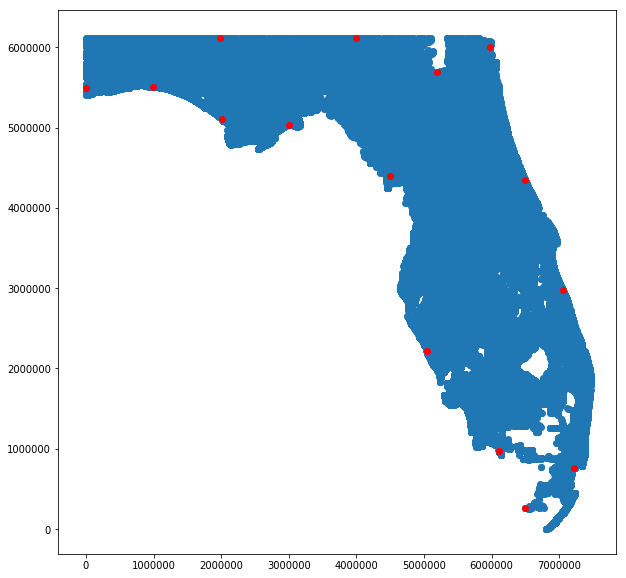

In [54]:
plt.figure(figsize=(10, 10)).add_subplot(1,1,1)

plt.scatter(nodes_x, nodes_y)
for landmark_i in precise_landmarks:
    plt.scatter(nodes_x[landmark_i], nodes_y[landmark_i], color='red', label='landmarks')

plt.show()

In [20]:
def choose_landmarks(input_node_coords: List[Coords], num_landmarks=15) -> List[int]:
    # =========================================================================================
    def coords2nparray(node_coords: List[Coords]):
        ret = []
        for node in node_coords:
            ret.append((node.x, node.y))
        
        return np.array(ret)
    
    def polar_coordinates_with_center(center: Coords, node: Coords) -> Tuple[float, float]:
        dx = node.x - center.x
        dy = node.y - center.y
        phi = math.atan2(dx, dy)
        if phi < 0:
            phi += 2 * math.pi
        
        return phi, math.hypot(dx, dy)
    # =========================================================================================
    
    node_coords = coords2nparray(input_node_coords)
    center = Coords(np.mean(node_coords[:, 0]), np.mean(node_coords[:, 1]))
    
    # =========================================================================================
    
    angle_bounds = [2 * math.pi * i / num_landmarks for i in range(num_landmarks)]
    
    # (distance from center to node in sector -> max, node index) 
    sector_landmarks = [(-math.inf, -1) for i in range(num_landmarks)]
    
    for i, node in tqdm(enumerate(input_node_coords)):
        phi, dist = polar_coordinates_with_center(center, input_node_coords[i])
        sector_num = int(phi * num_landmarks / (2 * math.pi))
        if dist > sector_landmarks[sector_num][0]:
            sector_landmarks[sector_num] = (dist, i)
    
    return [sector_landmarks[i][1] for i in range(num_landmarks)]
    
def precalculate_landmark_distances(landmarks: List[int],
                                    adj_lists: Dict[int, Dict[int, float]]) -> Dict[int, Dict[int, float]]:
    
    landmarks_dist = defaultdict(lambda: defaultdict(float))
    
    for landmark_i in tqdm(landmarks):
        print(landmark_i)
        landmarks_dist[landmark_i] = good_old_dijkstra(adj_lists, landmark_i)
    
    return landmarks_dist

def a_star_with_landmarks(adjacency_lists: Dict[int, Dict[int, float]], 
                          node_from, node_to, 
                          landmark_distances: Dict[int, Dict[int, float]]) -> Tuple[List[int], float]:
    """
    https://en.wikipedia.org/wiki/A*_search_algorithm
    Адаптация псевдокода из этой статьи под питон
    с некоторыми изменениями для того, чтобы все работало хоть немного оптимально
    """
    
    # по-хорошему надо было найти лэндмарку,
    # наиболее близкую к прямой, содержащей node_to и cur_v
    # но для нее просто достигается максимум разностей расстояний до node_to и до cur_v
    # так что возьмем за эвристику именно это расстояние
    # (на самом деле мне просто лень работать с геометрией)
    def heuristic_dist(cur_v_i: int, node_to_i: int):
        d = 0
        for lm_i in landmark_distances.keys():
            d = max(d, abs(landmark_distances[lm_i][node_to_i] - landmark_distances[lm_i][cur_v_i]))
        
        return d
    
    processed = set()
    
    processing = heapdict()
    # fscore = defaultdict(lambda: math.inf) -- хранится в ключе кучи для элемента
    prev = defaultdict(lambda: -1)
    gscore = defaultdict(lambda: math.inf)
    
    # ===========================Инициализация=====================================
    
    processing[node_from] = heuristic_dist(node_from, node_to)
    
    for node_i in adjacency_lists:
        processing[node_i] = math.inf
    
    gscore[node_from] = 0
    fscore[node_from] = heuristic_dist(node_from, node_to)
    
    prev[node_from] = node_from
    
    while processing:
        cur_node, cur_fscore = processing.popitem()
        
        if cur_node == node_to:
            break
        
        processed.add(cur_node)
        
        for neighbor in adjacency_lists[cur_node]:
            if neighbor in processed:
                continue
            
            tentative_gscore = gscore[cur_node] + adjacency_lists[cur_node][neighbor]
            if processing[neighbor] > tentative_gscore:
                prev[neighbor] = cur_node
                gscore[neighbor] = tentative_gscore
                processing[neighbor] = gscore[neighbor] + heuristic_dist(neighbor, node_to)
    
    dist = 0.0
    cur_v = node_to
    path = [cur_v]
    while prev[cur_v] != cur_v:
        dist += adj_lists[prev[cur_v]][cur_v]
        cur_v = prev[cur_v]
        path.append(cur_v)
    
    return path[::-1], dist
                

5813957 6116942
6124077 5349513
6708284 3999281
6973096 3575325
7287874 2403435
7343412 784851
6841122 10617
5804279 1027613
5036462 2228503
4772831 2792427
4669532 3180956
4792236 3488099
1827 6106888
2452740 6117146
4175823 6110368


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


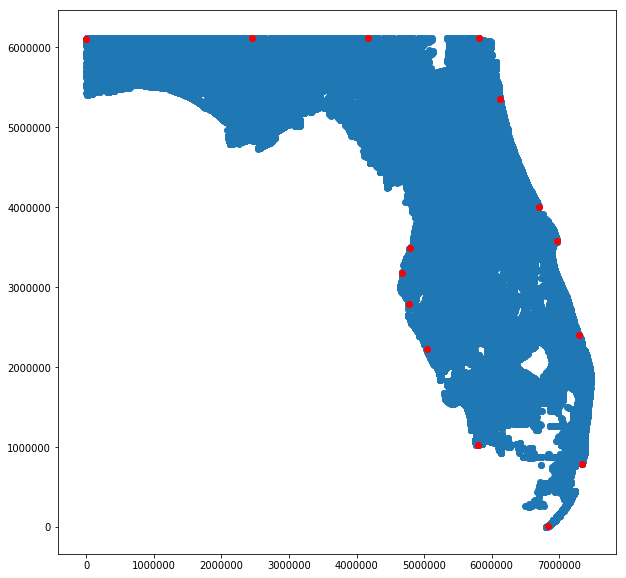

In [16]:
# посмотрим на наши лэндмарки (зачем? просто так)

node_coords = read_node_coords()
nodes_x = []
nodes_y = []
for coord in node_coords:
    nodes_x.append(coord.x)
    nodes_y.append(coord.y)


nodes_x = np.array(nodes_x)
nodes_y = np.array(nodes_y)

landmarks = choose_landmarks(node_coords)
# ============================================================

plt.figure(figsize=(10, 10))

plt.scatter(nodes_x, nodes_y)

for lm_i in landmarks:
    lm = node_coords[lm_i]
    print(lm.x, lm.y)
    plt.scatter(lm.x, lm.y, color='red')

plt.legend(loc='best')
plt.show()

In [19]:
import time
from random import randrange

def run_all():
    node_coords = read_node_coords()
    
    adjacency_lists = read_arcs()
    num_nodes = len(node_coords)
    
    time_start = time.monotonic()
    landmark_distances = precalculate_landmark_distances(choose_landmarks(node_coords), adjacency_lists)
    print('Precalculation done in {:.2} seconds.'.format(time.monotonic() - time_start))
    
    time_dijkstra = 0
    time_a_star = 0
    
    num_tests = 100
    for _ in trange(num_tests):
        node_from, node_to = randrange(num_nodes), randrange(num_nodes)
        time_start = time.monotonic()
        good_old_dijkstra(adjacency_lists, node_from, node_to)
        time_dijkstra += time.monotonic()-time_start
        time_start = time.monotonic()
        a_star_with_landmarks(adjacency_lists, node_from, node_to, landmark_distances)
        time_a_star += time.monotonic()-time_start
    
    print('Time elapsed in {} test: {:.2} second for A* vs. {:.2} seconds for Dijkstra.'.format(num_tests, time_a_star, time_dijkstra))

run_all()

1070376it [00:02, 456131.48it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Precalculation done in 2.1e+03 seconds.


NameError: name 'u' is not defined

In [ ]:
time_dijkstra = 0
time_a_star = 0

num_tests = 100
for _ in trange(num_tests):
    node_from, node_to = randrange(num_nodes), randrange(num_nodes)
    time_start = time.monotonic()
    good_old_dijkstra(adjacency_lists, node_from, node_to)
    time_dijkstra += time.monotonic()-time_start
    time_start = time.monotonic()
    a_star_with_landmarks(adjacency_lists, node_from, node_to, landmark_distances)
    time_a_star += time.monotonic()-time_start

print('Time elapsed in {} test: {:.2} second for A* vs. {:.2} seconds for Dijkstra.'.format(num_tests, time_a_star, time_dijkstra))


** Вот сейчас обидно было. До дедлайна остается 7 минут, и я боюсь, что на перезапуск у меня времени нет :(. heapdict был не лучшим выбором, надо было научиться докручивать к heapq.heapq метод decrease_key, чтобы работать с ним.  **